## Audio Classification with TIMIT dataset

In [ ]:
!pip3 install audiomentations

In [ ]:
!pip3 install timit-utils==0.9.0

! wget https://ndownloader.figshare.com/files/10256148 

!unzip -q 10256148

In [3]:
import timit_utils as tu
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  LabelEncoder

import IPython

_TIMIT_PATH = 'data/lisa/data/timit/raw/TIMIT'

In [4]:
def show_age_sex_distribution(dataset):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  dataset[dataset['mode'] == 'TRN']['age'].hist()
  dataset[dataset['mode'] == 'TST']['age'].hist()
  dataset[dataset['mode'] == 'VAL']['age'].hist()
  plt.legend(['TRN', 'TST', 'VAL'])
  plt.title('Age distribution')
  plt.subplot(1, 2, 2)
  dataset[dataset['mode'] == 'TRN']['sex'].hist()
  dataset[dataset['mode'] == 'TST']['sex'].hist()
  dataset[dataset['mode'] == 'VAL']['sex'].hist()
  plt.legend(['TRN', 'TST', 'VAL'])
  plt.title('Sex distribution')
  plt.show()

In [5]:
def show_confusion_matrix(confusion_mtx, labels):
  mtx = pd.DataFrame(confusion_mtx, columns=labels)
  sns.heatmap(mtx, annot=True, cmap='viridis')

In [6]:
def age_encoder(age):
  if age <= 30:
    return 0
  if 31 <= age <= 50:
    return 1
  if 51 <= age:
    return 2

In [7]:
with open('data/lisa/data/timit/raw/TIMIT/DOC/SPKRINFO.TXT') as f:
  text = f.readlines()

table = pd.DataFrame(index = range(len(text[39:])),
                     columns = ['name', 'mode', 'sex', 'age', 'age_gender']) 


for i in range(len(text[39:])):
  spkr_data = text[39:][i].split()
  table['name'][i] = spkr_data[0]
  table['sex'][i] = spkr_data[1]
  table['mode'][i] = spkr_data[3]
  table['age'][i] = age_encoder(int(spkr_data[4].split('/')[-1]) - int(spkr_data[5].split('/')[-1].replace('??', '50')))
  table['age_gender'][i] = (table['age'][i], table['sex'][i])
  table['dataset'] = 'TIMIT'

In [8]:
def age_gender_encoder(age_gender):
    label_encoder = LabelEncoder()
    return label_encoder.fit_transform(age_gender)

In [9]:
age_gender = [str(age)+gender for age, gender in table['age_gender']]

In [10]:
table['age_gender_encoded'] = age_gender_encoder(age_gender)

In [11]:
table['age_gender_encoded'].unique()

array([1, 3, 0, 2, 4, 5])

In [12]:
print(table.name.nunique())
print(len(table))

630
630


In [13]:
# division into TRN and VAL with respect to both age and sex
X = table[table['mode'] == 'TRN'].drop(columns=['age_gender_encoded'])
y = table[table['mode'] == 'TRN']['age_gender_encoded']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [14]:
for idx in range(len(table)):
  if table['name'][idx] in list(X_val['name']):
    table.at[idx, 'mode'] = 'VAL'

In [15]:
table.head(2)

,name,mode,sex,age,age_gender,dataset,age_gender_encoded
0,ABC0,VAL,M,0,"(0, M)",TIMIT,1
1,ABW0,TST,M,0,"(0, M)",TIMIT,1


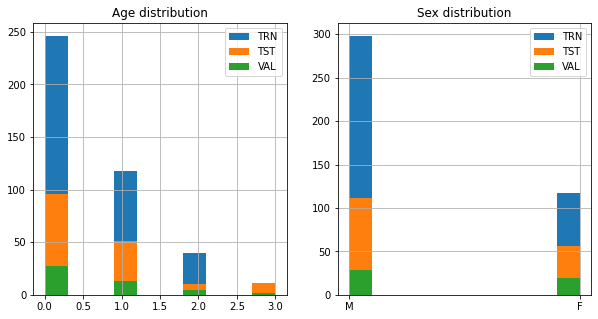

In [45]:
show_age_sex_distribution(table)

In [16]:
corpus = tu.Corpus(_TIMIT_PATH)

In [17]:
columns=['name', 'mode', 'sex', 'age', 'age_gender', 'dataset', 
        'age_gender_encoded', 'audio']

timit = dict(zip(columns, [[] for i in range(len(columns))]))

In [18]:
for name in tqdm(corpus.train.people_names+corpus.test.people_names):
  if name in corpus.train.people_names:
    person = corpus.train.person_by_name(name)
  else:
    person = corpus.test.person_by_name(name)
  for idx in range(len(person.sentences)):
    timit['name'].append(name)
    timit['mode'].append(table[table['name'] == name]['mode'].tolist()[0])
    timit['sex'].append(table[table['name'] == name]['sex'].tolist()[0])
    timit['age'].append(table[table['name'] == name]['age'].tolist()[0])
    timit['age_gender'].append(table[table['name'] == name]['age_gender'].tolist()[0])
    timit['dataset'].append(table[table['name'] == name]['dataset'].tolist()[0])
    timit['age_gender_encoded'].append(table[table['name'] == name]['age_gender_encoded'].tolist()[0])
    timit['audio'].append(person.sentence_by_index(idx).raw_audio)
  

100%|██████████| 630/630 [00:21<00:00, 29.61it/s]


In [19]:
timit = pd.DataFrame(timit)

In [20]:
print(len(timit[timit['mode'] == 'TRN']))
print(len(timit[timit['mode'] == 'VAL']))
print(len(timit[timit['mode'] == 'TST']))

4150
470
1680


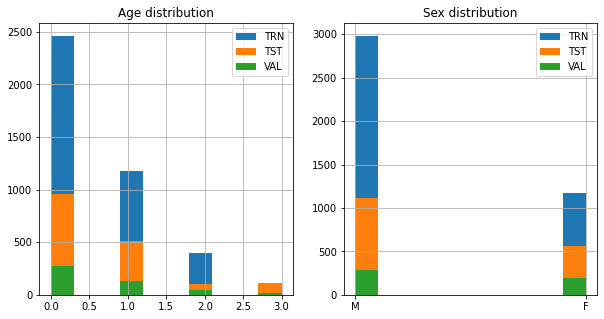

In [21]:
show_age_sex_distribution(timit)

In [21]:
class_counts = np.unique(timit[timit['mode'] == 'TRN']['age'], return_counts=True)
train_class_weights = 1. / class_counts[1]
print(class_counts)
print(train_class_weights)

(array([0, 1, 2]), array([2650, 1390,  110]))
[0.00037736 0.00071942 0.00909091]


In [22]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0., max_amplitude=10, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    Shift(min_fraction=-0.005, max_fraction=0.005, p=0.5),
])

In [23]:
class TIMIT_DATASET(Dataset):
    def __init__(self, dataset, sample_rate=16000, max_len=150, output_mode='spectrogram'): 
      self.dataset = dataset
      self.sample_rate = sample_rate
      self.max_len = max_len
      self.output_mode = output_mode
    
    def __getitem__(self, idx):
      row = self.dataset.iloc[idx]
      if self.output_mode == 'spectrogram':
        spectrogram = self.get_melspectrogram(augment(row['audio'], sample_rate=16000)) # [n_mels, time]
        spectrogram = torch.FloatTensor(self.spectrogram_to_image(spectrogram)).unsqueeze(0) # [1, n_mels, n_time_frame_bins]
        spectrogram = spectrogram.permute(0, 2, 1)
        target = torch.tensor(row['age'], dtype=torch.long)
        return {'input': spectrogram, 'target': target} 
      if self.output_mode == 'waveform':
        # preferable max_len=16000 due to lack of memory
        amplitudes = row['audio'][:self.max_len]
        amplitudes = self.spectrogram_to_image(np.hstack((amplitudes, np.array([0]*(self.max_len - len(amplitudes))))))
        waveform = torch.FloatTensor(amplitudes).unsqueeze(0) # dim = [1, T]
        target = torch.tensor(row['age'], dtype=torch.long)
        return {'input': waveform, 'target': target} 
    
    def spectrogram_to_image(self, spectrogram, eps=1e-6):
      mean = np.mean(spectrogram)
      std = np.std(spectrogram)
      spectrogram_norm = (spectrogram - mean) / (std + eps)
      spectrogram_min, spectrogram_max = np.min(spectrogram_norm), np.max(spectrogram_norm)
      spectrogram_scaled = 255 * (spectrogram_norm - spectrogram_min) / (spectrogram_max - spectrogram_min)
      spectrogram_scaled = spectrogram_scaled.astype(np.uint8)
      return spectrogram_scaled

    def get_melspectrogram(self, waveforms):
        spectrogram = librosa.feature.melspectrogram(waveforms, sr=self.sample_rate, n_mels=128, fmin=1, fmax=8192)[:, :self.max_len]  
        db_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, self.max_len - spectrogram.shape[1])]], mode='constant')
        return self.spectrogram_to_image(np.float32(spectrogram))

    def __len__(self):
      return len(self.dataset)

In [24]:
all_ages = timit[timit['mode'] == 'TRN']['age']

In [25]:
np.unique(np.array(all_ages), return_counts=True)

(array([0, 1, 2]), array([2650, 1390,  110]))

In [26]:
agetoweight = dict(zip(timit[timit['mode'] == 'TRN']['age'].unique(), train_class_weights))

In [27]:
all_weights = [agetoweight[age] for age in all_ages]

In [33]:
batch_size = 64

trainset = TIMIT_DATASET(timit[timit['mode'] == 'TRN'])
valset = TIMIT_DATASET(timit[timit['mode'] == 'VAL'])
testset = TIMIT_DATASET(timit[timit['mode'] == 'TST'])

weighted_sampler = WeightedRandomSampler(weights=all_weights, num_samples=len(all_ages), replacement=True)

train_dataloader = DataLoader(trainset, batch_size=batch_size, sampler=weighted_sampler)
val_dataloader = DataLoader(valset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)


In [34]:
def weights_init_normal(m):
  if isinstance(m, nn.Conv2d):
    torch.nn.init.normal_(m.weight, 0., 0.02)
  if hasattr(m, 'bias') and m.bias is not None:
    torch.nn.init.constant_(m.bias.data, 0.)

In [36]:
class SpectrogramConv(nn.Module):
    def __init__(self, window_sizes=(3, 4, 5)):
        super(SpectrogramConv, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(1, 256, kernel_size=(window_size, 128), padding=(window_size - 1, 0)) 
            for window_size in window_sizes
        ])

        self.fc = nn.Linear(256 * len(window_sizes), 3) 

    def forward(self, input):
        # input dim = [B, 1, T, F] - batch_size, n_channels, time, frequency
        x_convs = []
        for conv in self.convs:
            x = F.relu(conv(input))  # outdim = [B, C, T, 1]
            x = torch.squeeze(x, -1)  # outdim = [B, C, T]
            x = F.max_pool1d(x, x.size(2))  # outdim = [B, C, 1]
            x_convs.append(x)
        x = torch.cat(x_convs, 2)  # outdim = [B, C, 3]

        x = x.view(x.size(0), -1)  # outdim = [B, T * 3]
        logits = self.fc(x)  # outdim = [B, classes_distribution]
        return logits


In [80]:
class WaveformConv(nn.Module):
  def __init__(self, window_sizes=(3, 4, 5)):
        super(WaveformConv, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv1d(1, 128, kernel_size=window_size, padding=window_size - 1) 
            for window_size in window_sizes
        ])
        self.maxpool = nn.MaxPool1d(kernel_size=3, padding=1, stride=2)
        self.fc = nn.Linear(3072640, 4)

  def forward(self, input):
      x_convs = []
      for conv in self.convs:
          x = F.relu(conv(input))  
          x = self.maxpool(x)  
          x_convs.append(x)   
      x = torch.cat(x_convs, 2)  
      x = x.view(x.size(0), -1)  
      logits = self.fc(x)  
      return logits

In [37]:
n_epochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SpectrogramConv().to(device)
model.apply(weights_init_normal)
loss = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), betas=(0.9, 0.999), eps=1e-5, lr=1e-3)

In [38]:
for epoch in range(n_epochs):
  model.train()
  epoch_train_loss = []
  train_accuracy = []
  train_f1 = []
  for batch in train_dataloader:
      input, target = batch['input'].to(device), batch['target'].to(device) 

      optimizer.zero_grad()
      out = model(input)
      train_loss = loss(out, target)

      epoch_train_loss.append(train_loss.item())
    
      out = torch.argmax(out, dim=-1)

      train_accuracy.append(accuracy_score(target.cpu().numpy(), out.detach().cpu().numpy()))
      train_f1.append(f1_score(target.cpu().numpy(), out.detach().cpu().numpy(), average='weighted'))

      train_loss.backward()
      optimizer.step()
 
  model.eval()
  epoch_val_loss = []
  val_accuracy = []
  val_f1 = []
  with torch.no_grad():
    for batch in val_dataloader:
        input, target = batch['input'].to(device), batch['target'].to(device)

        out = model(input)
        val_loss = loss(out, target)

        epoch_val_loss.append(val_loss.item())

        out = torch.argmax(out, dim=-1)

        val_accuracy.append(accuracy_score(target.cpu().numpy(), out.detach().cpu().numpy()))
        val_f1.append(f1_score(target.cpu().numpy(), out.detach().cpu().numpy(), average='weighted'))
  
  print(f'----------------------------------Epoch {epoch}-------------------------------------')
  print("train_loss {}, val_loss {}".format(sum(epoch_train_loss)/len(epoch_train_loss), sum(epoch_val_loss)/len(epoch_val_loss)))
  print(f'train_F1: {sum(train_f1)/len(train_f1)}, val_F1: {sum(val_f1)/len(val_f1)}')
  print(f'train_Accuracy: {sum(train_accuracy)/len(train_accuracy)}, val_Accuracy: {sum(val_accuracy)/len(val_accuracy)}')
  print('------------------------------------------------------------------------------')

----------------------------------Epoch 0-------------------------------------
train_loss 14.156059622764587, val_loss 1.384728580713272
train_F1: 0.3694085352221713, val_F1: 0.47991045547429145
train_Accuracy: 0.43566595441595446, val_Accuracy: 0.47691761363636365
------------------------------------------------------------------------------
----------------------------------Epoch 1-------------------------------------
train_loss 1.2945507599757269, val_loss 1.0728600099682808
train_F1: 0.48277949258343844, val_F1: 0.5079700095549229
train_Accuracy: 0.5098112535612536, val_Accuracy: 0.533203125
------------------------------------------------------------------------------
----------------------------------Epoch 2-------------------------------------
train_loss 1.2119342253758356, val_loss 1.1700937747955322
train_F1: 0.4808603883577077, val_F1: 0.4950888798241705
train_Accuracy: 0.5163016381766382, val_Accuracy: 0.46235795454545453
-----------------------------------------------------

In [39]:
all_targets = []
all_outs = []
# trained on spectrogram model
model.eval()
test_accuracy = []
test_f1 = []
for batch in test_dataloader:
  input, target = batch['input'].to(device), batch['target'].to(device)

  out = model(input)
  out = torch.argmax(out, dim=-1)
  
  all_targets.append(target.cpu().numpy())
  all_outs.append(out.detach().cpu().numpy())

  test_accuracy.append(accuracy_score(target.cpu().numpy(), out.detach().cpu().numpy()))
  test_f1.append(f1_score(target.cpu().numpy(), out.detach().cpu().numpy(), average='weighted'))

print(f'test_F1: {sum(test_f1)/len(test_f1)}')
print(f'test_Accuracy: {sum(test_accuracy)/len(test_accuracy)}')

test_F1: 0.4325472580076784
test_Accuracy: 0.4212962962962963


In [40]:
all_targets = np.concatenate(all_targets, axis=-1)
all_outs = np.concatenate(all_outs)

In [44]:
confusion_mtx = confusion_matrix(all_targets, all_outs, labels=[0, 1, 2])
confusion_mtx

array([[607, 113, 320],
       [310,  56, 164],
       [ 51,  15,  44]])

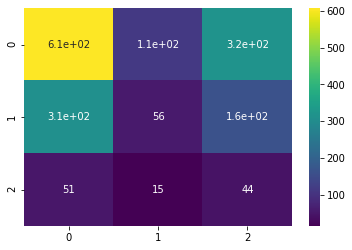

In [45]:
show_confusion_matrix(confusion_mtx, [0, 1, 2])